# Depths and Snow Pit Data Package Contents

Learning Objectives:
- Tools to access data
- Code snippets to extract and prep data

In [31]:
# standard imports
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np

#plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook'])

# unique imports
import s3fs #access data from the AWS s3 bucket

# Download snow depth data from NSIDC
From the SnowEx20 [Depth Probe Landing Page](https://nsidc.org/data/SNEX20_SD/versions/1), you can download data and access the [User's Guide](https://nsidc.org/sites/nsidc.org/files/SNEX20_SD-V001-UserGuide_1.pdf)
<img src="images/SD-landingPage.png">

The Community Snow Depth Probe data package is a single CSV with over 36,000 geolocated snow depths! Three different instrument types were used to measure depths and are recorded in the Measurement Tool column.

## Method 1: Programmatically download snow depth data from NSIDC

In [ ]:
%run './scripts/nsidc-download_SNEX20_SD.001.py' 
print('Grand Mesa 2020 Snow Depth data download complete') 

In [ ]:
# show filename:
path = Path('./data/depths/')

for filename in path.glob('*.csv'):
    print(filename.name)

## Method 2: Access data from the S3 bucket
Quick and easy access for hackweek or if you haven't gone through the steps to [configure programmatic access](https://snowex-hackweek.github.io/website/preliminary/earthdata.html#configure-programmatic-access-to-nasa-servers) to NASA servers yet. 

In [2]:
# Uses AWS credentials on machine
fs = s3fs.S3FileSystem() 

# which data bucket?
bucket = 'snowex-data'  
      
# contents inside /depths     
flist = fs.ls(f'{bucket}/tutorial-data/core-datasets/depths') 

# show filename
print('File list is: ', flist)

File list is:  ['snowex-data/tutorial-data/core-datasets/depths/SnowEx2020_SnowDepths_COGM_alldepths_v01.csv']


## Read the Depth File

In [3]:
# open depth data file, and create pandas dataframe
with fs.open(flist[0], 'rb') as f: 
    
    df = pd.read_csv(f, sep=',', header=0, parse_dates=[[2,3]]) #parse the date[2] and time[3] columns such that they are read in as datetime dtypes
    
print('file has been read, and is ready to use.')

file has been read, and is ready to use.


In [4]:
# check data types for each column
df.dtypes

Date (yyyymmdd)_Time (hh:mm, local, MST)                           datetime64[ns]
Measurement Tool (MP = Magnaprobe; M2 = Mesa 2; PR = Pit Ruler)            object
ID                                                                          int64
PitID                                                                      object
Longitude                                                                 float64
Latitude                                                                  float64
Easting                                                                   float64
Northing                                                                  float64
Depth (cm)                                                                  int64
elevation (m)                                                             float64
equipment                                                                  object
Version Number                                                              int64
dtype: object

## Prep for Data Analysis

In [5]:
# rename some columns for ease further down
df.rename(columns = {
    'Measurement Tool (MP = Magnaprobe; M2 = Mesa 2; PR = Pit Ruler)':'Measurement Tool', 
    'Date (yyyymmdd)_Time (hh:mm, local, MST)': "Datetime"},
          inplace = True)

# set up filter for IOP date range
start = pd.to_datetime('1/28/2020') #first day of GM IOP campaign
end   = pd.to_datetime('2/12/2020') #last day of GM IOP campaign

# filter the IOP date range
df = df[(df['Datetime'] >= start) & (df['Datetime'] <= end)]

print('DataFrame shape is: ', df.shape)
df.head()

DataFrame shape is:  (36388, 12)


,Datetime,Measurement Tool,ID,PitID,Longitude,Latitude,Easting,Northing,Depth (cm),elevation (m),equipment,Version Number
0,2020-01-28 11:48:00,MP,100000,8N58,-108.13515,39.03045,747987.62,4324061.71,94,3148.2,CRREL_B,1
1,2020-01-28 11:48:00,MP,100001,8N58,-108.13516,39.03045,747986.75,4324061.68,74,3148.3,CRREL_B,1
2,2020-01-28 11:48:00,MP,100002,8N58,-108.13517,39.03045,747985.89,4324061.65,90,3148.2,CRREL_B,1
3,2020-01-28 11:48:00,MP,100003,8N58,-108.13519,39.03044,747984.19,4324060.49,87,3148.6,CRREL_B,1
4,2020-01-28 11:48:00,MP,100004,8N58,-108.13519,39.03042,747984.26,4324058.27,90,3150.1,CRREL_B,1


## Use .groupby() to sort the data set

In [6]:
# group data by the measurement tool 
gb = df.groupby('Measurement Tool', as_index=False).mean().round(1)

# show mean snow depth from each tool
gb[['Measurement Tool', 'Depth (cm)']]

,Measurement Tool,Depth (cm)
0,M2,97.0
1,MP,94.8
2,PR,94.6


## ***Your turn***

In [7]:
# group data by the snow pit ID


# show mean snow depth around each snow pit


#(hint: what is the pit id column called? If you're not sure you can use df.columns to see a list of column names. Consider using .head() to display only the first 5 returns)

## Find depths associated with a certain measurement tool

In [8]:
print('List of Measurement Tools: ', df['Measurement Tool'].unique())

List of Measurement Tools:  ['MP' 'M2' 'PR']


In [9]:
r = df.loc[df['Measurement Tool'] == 'PR']
print('DataFrame shape is: ', r.shape)
r.head()

DataFrame shape is:  (148, 12)


,Datetime,Measurement Tool,ID,PitID,Longitude,Latitude,Easting,Northing,Depth (cm),elevation (m),equipment,Version Number
37755,2020-01-30 11:24:00,PR,300001,7C15,-108.19593,39.04563,742673.94,4325582.37,100,3048.699951,ruler,1
37756,2020-01-29 15:00:00,PR,300002,6C37,-108.14791,39.00760,746962.00,4321491.00,117,3087.709961,ruler,1
37757,2020-02-09 12:30:00,PR,300003,8C31,-108.16401,39.02144,745520.00,4322983.00,98,3099.639893,ruler,1
37758,2020-01-28 09:13:00,PR,300004,6N18,-108.19103,39.03404,743137.23,4324309.43,92,3055.590088,ruler,1
37760,2020-02-10 10:30:00,PR,300006,8S41,-108.14962,39.01659,746783.00,4322484.00,95,3113.870117,ruler,1


## ***Your turn***

In [10]:
# find all depths recorded by the Mesa2


# (hint: copy/paste is your friend)

Let's make sure we all have the same pd.DataFrame() again

In [11]:
# pit ruler snow depths from Grand Mesa IOP
r = df.loc[df['Measurement Tool'] == 'PR'] 

## Plotting

Text(0, 0.5, 'Northing [m]')

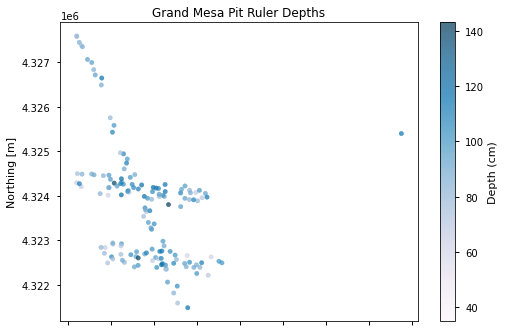

In [12]:
# plot pit ruler depths
ax = r.plot(x='Easting', y='Northing', c='Depth (cm)', kind='scatter', alpha=0.7, colorbar=True, colormap='PuBu', legend=True)
ax.set_title('Grand Mesa Pit Ruler Depths')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')

Text(0, 0.5, 'Snow Depth (cm)')

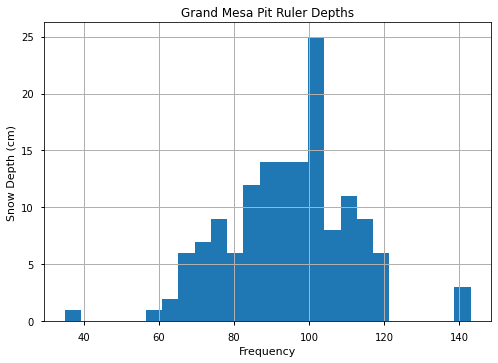

In [13]:
ax = r['Depth (cm)'].plot.hist(bins=25)
ax.grid()
ax.set_title('Grand Mesa Pit Ruler Depths')
ax.set_xlabel('Frequency')
ax.set_ylabel('Snow Depth (cm)')


# Download snow pit data from NSIDC
From the SnowEx20 [Snow Pit Landing Page](https://nsidc.org/data/SNEX20_GM_SP/versions/1), you can download data and access the [User's Guide](https://nsidc.org/data/SNEX20_GM_SP/versions/1). 

<img src="images/SP-landingPage.png">



In [ ]:
# load snow pit data
%run 'scripts/nsidc-download_SNEX20_GM_SP.001.py'
print('Grand Mesa 2020 Snow Pit data download complete')

In [ ]:
path = Path('./data/pits/')

for i, filename in enumerate(path.glob('*5N19*')):
    print(i, filename.name)

In [14]:
# Uses AWS credentials on machine
fs = s3fs.S3FileSystem() 

# which data bucket?
bucket = 'snowex-data'  
      
# contents inside /pits     
flist = fs.ls(f'{bucket}/tutorial-data/core-datasets/pits/')

# which files do we want?
suffix='.csv'

# list comprehension to get .csv files (not .xlsx or .jpgs)
csv_files = [filename for filename in flist if filename.endswith(suffix)]

In [56]:
# what files would you like to find?
parameter = 'temperature'
pitID = '5N19'

def parameter(filename_list):
    pass
def pit_id():
    pass

In [57]:
pitID

'5N19'

In [ ]:
temp_files = []
for f in csv_files:
    if 'temperature' in f:
        temp_files.append()
    
temp_files

# # show filename
# print('File list is: \n', flist)

In [60]:
with fs.open('/snowex-data/tutorial-data/core-datasets/pits/SnowEx20_SnowPits_GMIOP_20200128_5N19_temperature_v01.csv', 'rb') as f:

    t = pd.read_csv(f, header=7)
t

,# Height (cm),Temperature (deg C)
0,102,-9.5
1,100,-9.4
2,90,-11.5
3,80,-7.5
4,70,-5.2
5,60,-4.1
6,50,-3.5
7,40,-3.0
8,30,-2.5
9,20,-2.1


Text(0, 0.5, 'Snow Depth (cm)')

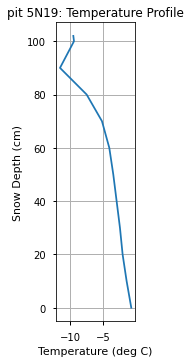

In [61]:
# plot temperature
t['Temperature (deg C)'].max()

ax = t.plot(x='Temperature (deg C)',y='# Height (cm)', legend=False)
ax.set_aspect(0.4)
ax.grid()
ax.set_title('pit {}: Temperature Profile'.format(pitID))
ax.set_xlabel('Temperature (deg C)')
ax.set_ylabel('Snow Depth (cm)')

In [62]:
with fs.open('/snowex-data/tutorial-data/core-datasets/pits/SnowEx20_SnowPits_GMIOP_20200128_5N19_density_v01.csv', 'rb') as f:

    d = pd.read_csv(f, header=7)
d

,# Top (cm),Bottom (cm),Density A (kg/m3),Density B (kg/m3),Density C (kg/m3)
0,102.0,92.0,136.0,138.0,NaN
1,92.0,82.0,193.0,192.0,NaN
2,82.0,72.0,232.0,221.0,NaN
3,72.0,62.0,262.0,260.0,NaN
4,62.0,52.0,275.0,278.0,NaN
5,52.0,42.0,261.0,252.0,NaN
6,42.0,32.0,267.0,269.0,NaN
7,32.0,22.0,336.0,367.0,NaN
8,22.0,12.0,268.0,246.0,NaN
9,12.0,2.0,262.0,271.0,NaN


In [65]:
#average density columns
d['Avg Density (kg/m3)'] = d[['Density A (kg/m3)', 'Density B (kg/m3)']].mean(axis=1)
d

,# Top (cm),Bottom (cm),Density A (kg/m3),Density B (kg/m3),Density C (kg/m3),Avg Density (kg/m3)
0,102.0,92.0,136.0,138.0,NaN,137.0
1,92.0,82.0,193.0,192.0,NaN,192.5
2,82.0,72.0,232.0,221.0,NaN,226.5
3,72.0,62.0,262.0,260.0,NaN,261.0
4,62.0,52.0,275.0,278.0,NaN,276.5
5,52.0,42.0,261.0,252.0,NaN,256.5
6,42.0,32.0,267.0,269.0,NaN,268.0
7,32.0,22.0,336.0,367.0,NaN,351.5
8,22.0,12.0,268.0,246.0,NaN,257.0
9,12.0,2.0,262.0,271.0,NaN,266.5


<AxesSubplot:>

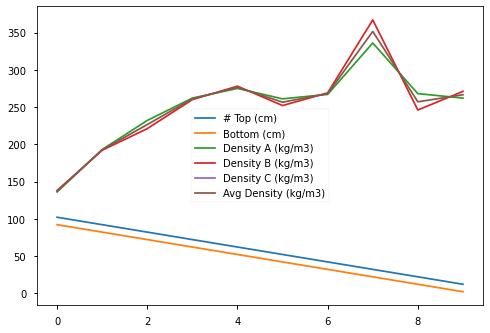

In [66]:
d.plot()